
## STOCHASTIC MODELING
MODULE 6 | LESSON 2


---

# **MULTI-ARMED BANDITS: Practice**

|  |  |
|:---|:---|
|**Reading Time** |  30 min |
|**Prior Knowledge** |Markov process, Optimization, Monte Carlo  |
|**Keywords** |Reinforcement learning, multi-armed bandits


---

*In this notebook, we introduce the theory to understand the stationary k-bandit problem presented in the next lesson. This lecture represents the first building block in order to understand more complex versions of k-bandit models. Make sure you understand this properly because it is going to lay the foundation for the next lesson (non-stationary k-bandit problem).*<span style='color: transparent; font-size:1%'>All rights reserved WQU WorldQuant University QQQQ</span>

## **1. A Stationary $k$-bandit Problem**

We are going to focus this second lesson on the implementation of optimal choices in the context of a $k$-armed bandit stationary problem. Before starting, let's upload the libraries we need in this module.

In [1]:
# LOAD LIBRARIES

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import rand, seed

The core of the algorithm is made of two pieces within each time step: first, an optimal action choice given information about the past, and second, an updating of the expected reward from choosing the given action.

The next block of code defines the function that performs optimal action selection. In the policy choice, the function takes an array that provides information about the rewards obtained in the past from each action and some parameter that determines the probability of not being *greedy*. If not greedy, the agent chooses randomly across actions with equal probability. The function also takes care of the existence of ties, mostly relevant in the initial time steps of an episode. 

In [2]:
def optimal_action(qvalue, eps):
    """
    Determines what is the action to take given a measure of past
    expected rewards across actions. With probability eps the action
    is not the greedy one
    """
    nactions = qvalue.shape[0]
    action_hat = np.where(qvalue == np.max(qvalue))

    if rand() <= eps:
        randnum = rand()
        for aa in range(nactions):
            if randnum < (aa + 1) / nactions:
                break
    elif action_hat[0].shape[0] > 1:
        # Randomize action when ties
        randnum = rand()
        for aa in range(action_hat[0].shape[0]):
            if randnum < (aa + 1) / action_hat[0].shape[0]:
                break
        aa = action_hat[0][aa]
    else:
        aa = np.argmax(qvalue)

    return aa

The next block of code implements the second step of the algorithm. That is, the new update on the action-value given the choice that comes out of the previous function.

In [3]:
def reward_update(action, reward, qvalue_old, alpha):
    qvalue_new = qvalue_old.copy()

    qvalue_new[action] = qvalue_old[action] + alpha * (reward - qvalue_old[action])

    return qvalue_new

We will study the learning ability of an agent in the context of a 10-armed bandit problem. The average payoff from each bandit comes from the draws of a standard normal distribution, while the rewards of choosing each arm come from a normal distribution centered at the corresponding mean, with a unit standard deviation.

The role of the agent is to learn from experience what is the arm that yields the highest expected value. We are going to evaluate the performance of the agent to learn over a run, or "episode," of 1,000 time steps. Evaluation of the learning ability of the agent over a single history may be contaminated by "too much randomness." Thus, we allow the agent to make 1,000 episodes, more than enough to reduce noise. We check the learning ability of the agent by averaging, at each time step, the rewards obtained by the agent across all episodes. 

In [4]:
# EXAMPLE OF A STATIONARY k-BANDIT PROBLEM
# Parameters
NK = 10
ITEMAX = 1000
EPSILON_M = [0.0, 0.1]
NEPISODES = 1000

seed(1234)

# Initialize actual distribution of each bandit
NMEANS = np.random.normal(loc=0.0, scale=1.0, size=NK)

print(NMEANS)

[ 0.47143516 -1.19097569  1.43270697 -0.3126519  -0.72058873  0.88716294
  0.85958841 -0.6365235   0.01569637 -2.24268495]


Notice that action 3 is the optimal action to take.

We will compare the learning ability of a *$\varepsilon$-greedy* action policy as compared to a purely greedy policy. The comparison can be made according to two statistics (i) the average reward across episodes at the same time step, and (ii) the average times that the actual optimal action was taken across episodes in the same time step. For this, we initialize two arrays that are going to store each measure of performance for each time step and $\varepsilon$.

You can easily check the performance of the agent for a broader set of $\varepsilon$. We leave this as an exercise.

In [5]:
reward_avg = np.zeros((ITEMAX, 2))
optimal_avg = np.zeros((ITEMAX, 2))

Now let's check the performance of each policy.

In [6]:
for ee in range(2):
    epsilon = EPSILON_M[ee]
    for run in range(NEPISODES):
        # Initialize q function and actions record
        qvalue = np.zeros((NK))
        nchoices = np.zeros((NK))
        for tt in range(ITEMAX):
            aa_opt = optimal_action(qvalue, epsilon)
            reward = np.random.normal(loc=NMEANS[aa_opt], scale=1.0)
            nchoices[aa_opt] += 1  # update with avg. number of times aa_opt was chosen
            qvalue = reward_update(aa_opt, reward, qvalue, 1 / nchoices[aa_opt])
            reward_avg[tt, ee] += reward / NEPISODES
            optimal_avg[tt, ee] += (aa_opt == np.argmax(NMEANS)) / NEPISODES

Let's plot the results.

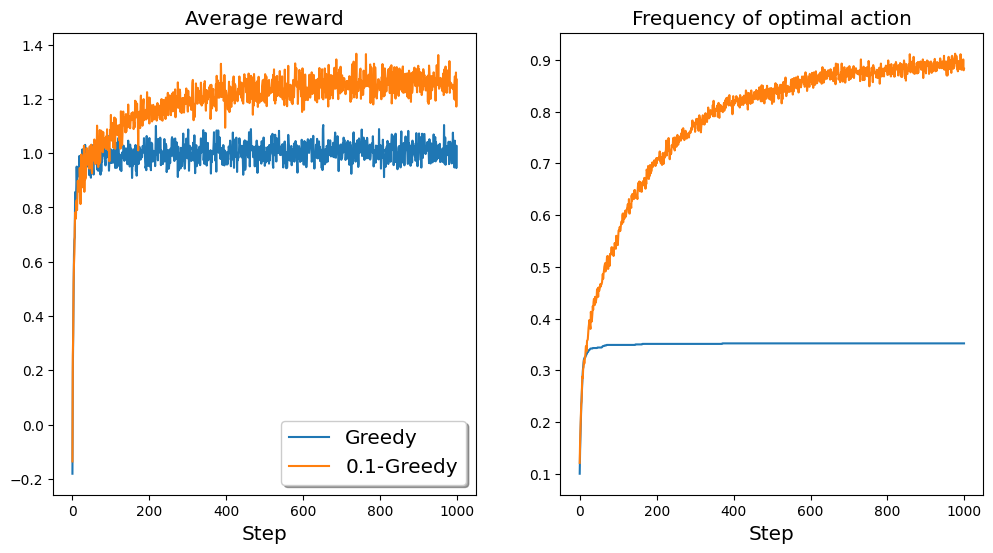

In [7]:
plt.subplot(1, 2, 1)
plt.plot(reward_avg[:, 0], label="Greedy")
plt.plot(reward_avg[:, 1], label="0.1-Greedy")
plt.xlabel("Step", fontsize="x-large")
plt.title("Average reward", fontsize="x-large")
legend = plt.legend(loc="lower right", shadow=True, fontsize="x-large")
plt.subplot(1, 2, 2)
plt.plot(optimal_avg[:, 0], label="Greedy")
plt.plot(optimal_avg[:, 1], label="0.1-Greedy")
plt.xlabel("Step", fontsize="x-large")
plt.title("Frequency of optimal action", fontsize="x-large")
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.show()

The greedy method learns slightly faster than the other method at the beginning but then reaches a lower average reward. It achieves a reward-per-step of only about 1, compared with the best possible of about 1.43. The greedy method performs worse in the long run because it gets stuck performing suboptimal actions.

The other graph shows that the greedy method finds the optimal action in roughly one-third of the steps. The $\varepsilon$-greedy method eventually performs better because its exploration of other actions in search of the optimal one. You can verify that the long-term performance of a low $\varepsilon$ is better, so it is possible to reduce the parameter over the steps to maximize the advantages of both high and low values.

The advantage of $\varepsilon$-greedy over greedy methods depends on the task. For instance, noisier rewards (higher variance) increases the long-term advantages of exploring the action space and, thus, make $\varepsilon$-greedy more efficient. On the other hand, with low variances, the greedy method would quickly find the optimal action and then never explore. But even in the deterministic case, there is a large advantage to exploring if we weaken some of the other assumptions, such as non-stationarity.

## **2. Conclusion**

In this lesson, we have worked through concepts of k-bandit problems in the stationary case. In the next lesson, we will extend the problem to non-stationary applications.

See you there!

---
Copyright 2025 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
